# Homework 5 (EOF Analysis of ERSST)

In [1]:
import os
from statistics import mode

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import xarray as xr
import xskillscore as xs
import matplotlib.colors as colors 
from scipy.optimize import curve_fit
from scipy.stats import gamma, kurtosis, linregress, norm, ranksums, skew
from scipy.stats import ttest_ind as ttest
from tabulate import tabulate

import dask as da

# Util Functions

In [2]:
def xarray_time_to_monthly(ds):
    """
    Converts xarray from dims (time of type np.datatype64[M]) to (year, month) where year are integers and month are integers from 1 to 12

    Arguments:
    -----------
        ds [Dataset, DataArray](..., time)

    Returns:
    --------
        ds [Dataset, DataArray](..., year, month)
    """
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")


def xarray_monthly_to_time(df):
    """
    Converts xarray from dims (year, month) where year are integers and month are integers from 1 to 12 to (time of type np.datatype64[M])

    Arguments:
    -----------
        ds [Dataset, DataArray](..., year, month)

    Returns:
    --------
        ds [Dataset, DataArray](..., time)
    """
    # get first and last year
    firstYr, lastYr = df.year[0], df.year[-1] + 1
    
    # create time dimension
    df = df.stack(time=["year", "month"])
    
    # set time dimensions using first and last yr
    df["time"] = np.arange(f"{firstYr}-01", f"{lastYr}-01", dtype="datetime64[M]")
    
    return df

def xarray_latlon_to_space(df):
    """
    Converts xarray from dims (lat, lon) to space which is a tuple of floats (lat, lon)

    Arguments:
    -----------
        ds [Dataset, DataArray](..., lat, lon)

    Returns:
    --------
        ds [Dataset, DataArray](..., space)
    """
    # get first and last year
    lat, lon = df.lat, df.lon
    
    # create time dimension
    df = df.stack(space=["lat", "lon"])
    
    return df
    
def xarray_monthly_to_time(df):
    """
    Converts xarray from dims (year, month) where year are integers and month are integers from 1 to 12 to (time of type np.datatype64[M])

    Arguments:
    -----------
        ds [Dataset, DataArray](..., year, month)

    Returns:
    --------
        ds [Dataset, DataArray](..., time)
    """
    # get first and last year
    firstYr, lastYr = df.year[0], df.year[-1] + 1
    
    # create time dimension
    df = df.stack(time=["year", "month"])
    
    # set time dimensions using first and last yr
    df["time"] = np.arange(f"{firstYr}-01", f"{lastYr}-01", dtype="datetime64[M]")
    
    return df

def detrend_data(data, x, x_dim, deg=1):
    """
    Detrend data using n-degree least squares fit

    Arguments:
    -----------
        data [Dataset, DataArray](..., x_dim): data to detrend (y)
        x [DataArray](x_dim): dimension to detrend along (x)
        x_dim ([tr]: name of dimension along which to detrend
        deg [int]: degree of polynomial to fit

    Returns:
    --------
        da [Dataset](..., sia, sie): detrended data
    """
    results = data.polyfit(dim=x_dim, skipna=True, deg=deg)
    new_data = data - xr.polyval(x, results.polyfit_coefficients)
    da = xr.DataArray(new_data, coords=data.coords, dims=data.dims, attrs=data.attrs)
    return da


# Preprocess 

In [3]:
""" LOAD and PREPROCESS ERSST Data"""
# Load
fp = "/glade/work/zespinosa/Courses/Objective_Analysis/HW5"
sst = xr.open_dataset(os.path.join(fp, "sst.mnmean.nc"), chunks="auto").sst
# Reshape (time, lat, lon) => (year, month, lat, lon)
sst = xarray_time_to_monthly(sst)
# Subset time to 1900-01-01 - 2022-31-12
sst = sst.sel(year=np.arange(1900, 2023)) 
# Linearly detrend sst data at each point for each month
sst = detrend_data(sst, sst.year, "year")

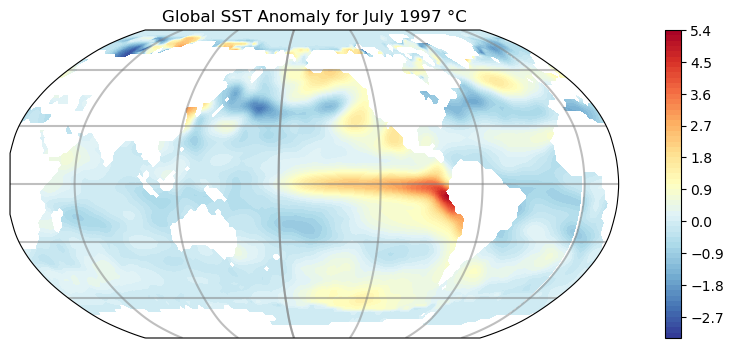

In [4]:
# Sanity check global values
def global_plot(sst, lon, lat): 
    # let's try to plot a monthly mean
    plt.figure(figsize=(12, 4), dpi=100)

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-160))

    plt.contourf(lon, lat, sst, 60, cmap = 'RdYlBu_r',
                 transform=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
    # ax.coastlines() # current issue with adding coastlines. For now, just ignore but we need to figure this out later
    plt.colorbar()

    plt.title('Global SST Anomaly for July 1997 \N{DEGREE SIGN}C')
    plt.show()
    
global_plot(
    sst=sst.sel(year=1997, month=7),
    lon=sst.lon,
    lat=sst.lat
)

In [5]:
import cartopy
print(cartopy.config)

{'pre_existing_data_dir': '', 'data_dir': '/glade/u/home/zespinosa/.local/share/cartopy', 'cache_dir': '/glade/scratch/zespinosa/cartopy_cache_dir', 'repo_data_dir': '/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/cartopy/data', 'downloaders': {('shapefiles', 'natural_earth'): <cartopy.io.shapereader.NEShpDownloader object at 0x2acb42e6fd90>, ('shapefiles', 'gshhs'): <cartopy.io.shapereader.GSHHSShpDownloader object at 0x2acb42e79f10>}}


In [6]:
# Convert out matrix from (year, month, lat, lon) to (space, time) = (lonxlat, yearxmonth)
sst_time = xarray_monthly_to_time(sst)
sst_space_time = xarray_latlon_to_space(sst_time)
sst_space_time = sst_space_time.dropna(dim="space") # Drop all nans in space
sst_space_time = sst_space_time.dropna(dim="time") # Drop all nans in time

In [7]:
sst_space_time # this is roughly the same size as Dennis got from using to topography mask to remove land, but here I simply drop all (lat,lon) with nans

<xarray.DataArray (time: 1476, space: 10988)>
dask.array<getitem, shape=(1476, 10988), dtype=float64, chunksize=(1476, 10988), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2022-12-01
  * space    (space) object MultiIndex
  * lat      (space) float32 88.0 88.0 88.0 88.0 ... -76.0 -76.0 -76.0 -76.0
  * lon      (space) float32 0.0 2.0 4.0 6.0 8.0 ... 326.0 328.0 330.0 332.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

# Examine Eignevalue Spectrum

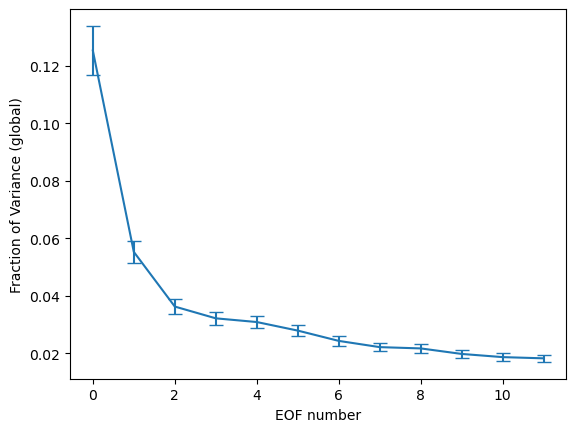

Confirm that this is a time series:  (1476,)


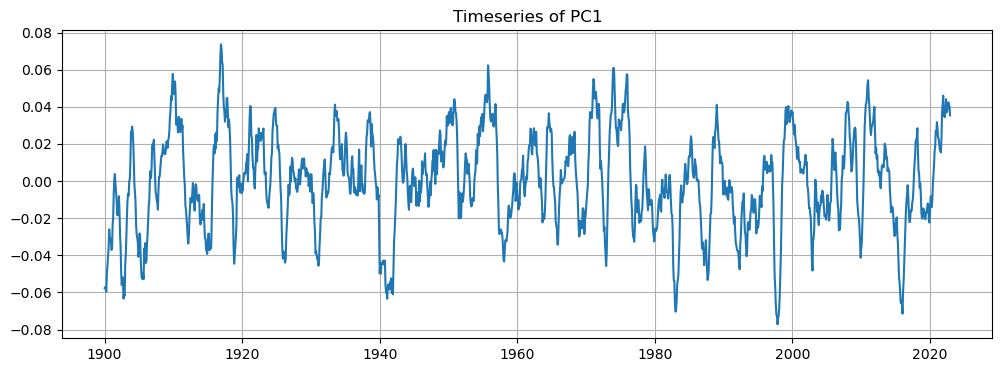

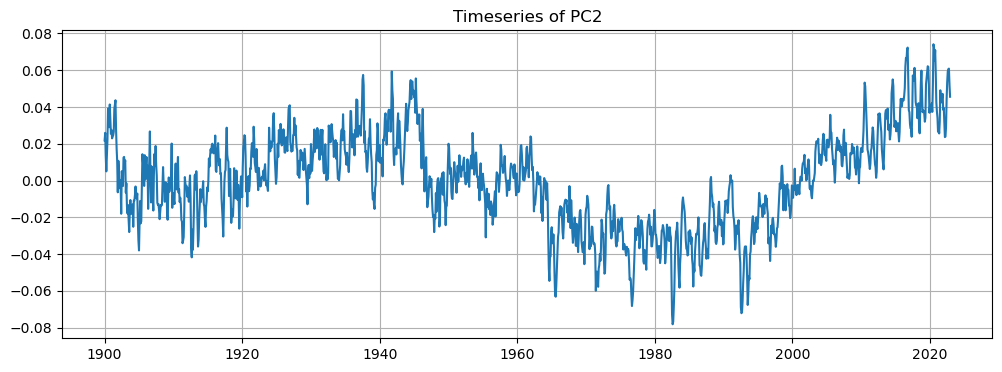

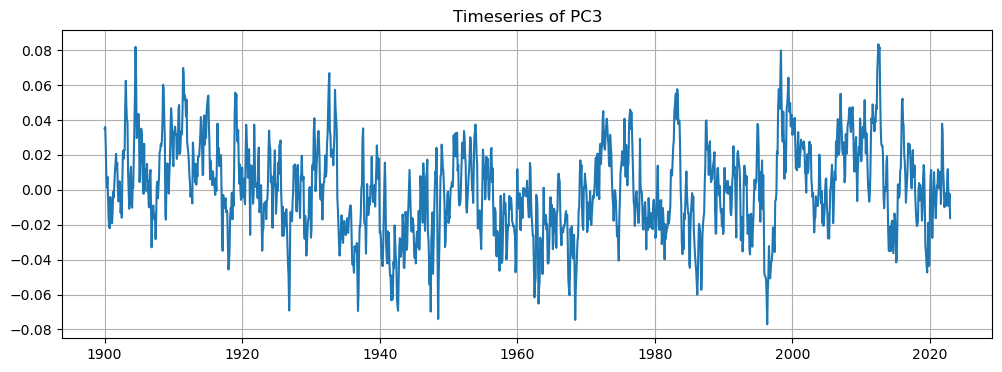

In [8]:
# First get degrees of freedom
# NOTE TO SELF: I don't understand Chapter 5 of text, so read Bretherton et al., 1999 instead
dof_sst = 429 

# Second Computer Eigenvalue Spectrum
u, s, vh = np.linalg.svd(sst_space_time.T)
spectrum = s*s.T
spectrum = spectrum/sum(spectrum)
yerror = spectrum*np.sqrt(2/dof_sst)

# Third Plot Eigenvalue Spectrum
def plot_eigenvalue_spectrum():
    """
    My values differ slightly from those generated by Dennis
    """
    index = np.linspace(0,24,25)
    plt.errorbar(index[0:12],spectrum[0:12],yerror[0:12],capsize=5)
    plt.ylabel('Fraction of Variance (global)')
    plt.xlabel('EOF number')
    plt.show()
    
plot_eigenvalue_spectrum()

# Plot time series of first eof
ts = vh[0,:]
print("Confirm that this is a time series: ", ts.shape)
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(sst_space_time.time,ts)
plt.title('Timeseries of PC1')
plt.grid()

# Plot time series of second eof
ts = vh[1,:]
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(sst_space_time.time,ts)
plt.title('Timeseries of PC2')
plt.grid()

# Plot time series of third eof
ts = vh[3,:]
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(sst_space_time.time,ts)
plt.title('Timeseries of PC3')
plt.grid()

# Examine Map of Regression for EOF X 

In [9]:
# Plotting function for global regression maps
def global_regression_plot(sst, lon, lat, title): 
    # let's try to plot a monthly mean
    plt.figure(figsize=(12, 4), dpi=100)

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-160))

    plt.contourf(lon, lat, sst, np.arange(-.9, 1.0, .05), cmap = 'RdYlBu_r',
                 transform=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
    # ax.coastlines() # current issue with adding coastlines. For now, just ignore but we need to figure this out later
    plt.colorbar()
    
    ax.add_feature(cartopy.feature.LAND, facecolor="grey", edgecolor="black", zorder=3)

    plt.title(f'Regression for {title} 1900-2022 \N{DEGREE SIGN}C')
    plt.show()

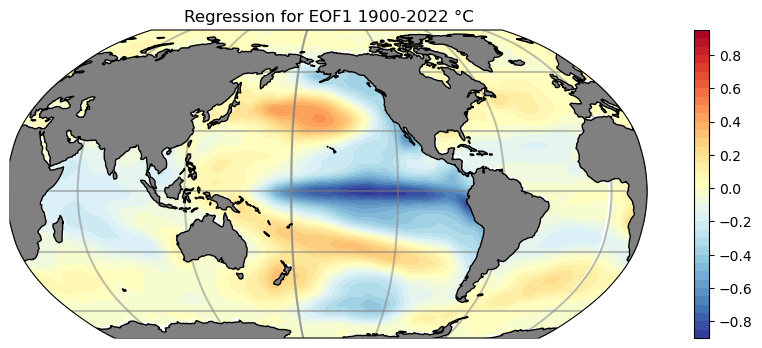

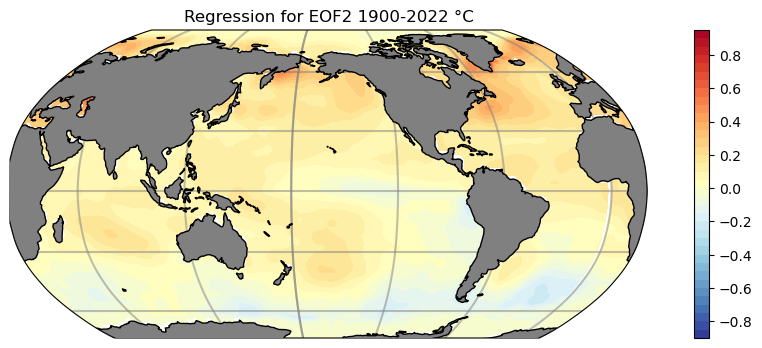

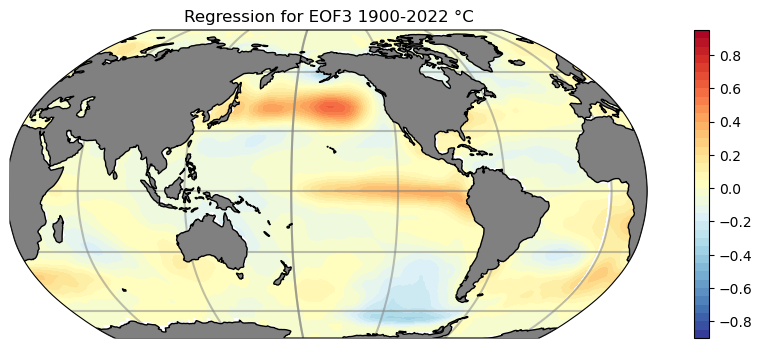

In [10]:
def calc_regressions(
    df, # Original data frame
    pcs, # Principal components matrix
    num_regs=3, # Number of regressions to plot
    plot_func=True # Function to use for plotting 
):
    for i in range(num_regs):
        # Get first PC and standardize
        t = pcs[i,:]/np.std(pcs[i,:])
        # Regress first PC onto original data and divide by number samples
        reg = np.matmul(t, df.to_numpy()) / t.shape[0]
        reg_org = df[0]
        reg_org.values = reg
        reg_org = reg_org.unstack("space")

        global_regression_plot(
            reg_org, 
            lat=reg_org.lat, 
            lon=reg_org.lon,
            title=f"EOF{i+1}"
        )
    

calc_regressions(
    df=sst_space_time, 
    pcs=vh, 
    num_regs=3, 
    plot_func=True 
)

# Southern Ocean (repeat)

In [11]:
def plot_stationary_sp(minLon=-180, maxLon=180):
    import matplotlib.path as mpath
    """
    Create a stationary centered on south pole (Longitude: [minLon,maxLon]; Latitude: [-90,-60]
    Returns:
        ax, fig
    """
    fig = plt.figure(figsize=[10, 5])
    ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)

    # Limit the map to -60 degrees latitude and below.
    ax1.set_extent([minLon, maxLon, -90, -50], ccrs.PlateCarree())

    ax1.gridlines(draw_labels=True, color="black", linestyle="dashed", zorder=101)
    ax1.tick_params(which="both", zorder=103)

    ax1.add_feature(cartopy.feature.LAND, facecolor="grey", edgecolor="black", zorder=3)
    ax1.add_feature(cartopy.feature.OCEAN, facecolor="#f4f5f5")

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax1.set_boundary(circle, transform=ax1.transAxes)

    return fig, ax1

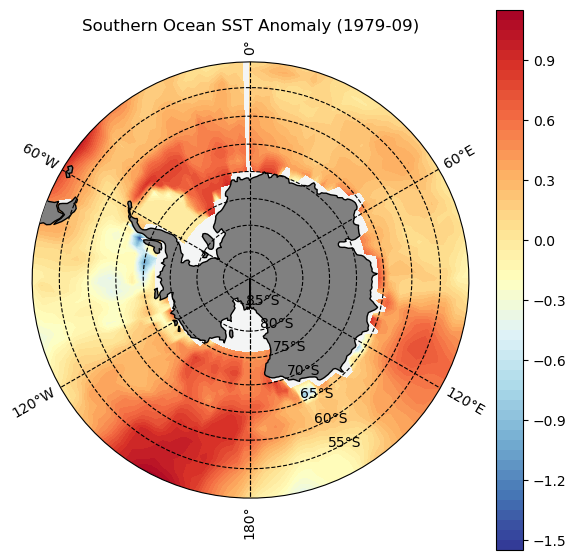

In [12]:
# Select southern ocean
sst_so = sst.sel(lat=np.arange(-88, -48, 2))

# Sanity check selection of southern ocean
fig, ax = plot_stationary_sp()
img = ax.contourf(
    sst_so.lon,
    sst_so.lat,
    sst_so.sel(year=1979, month=2),
    60,
    transform=ccrs.PlateCarree(), 
    cmap="RdYlBu_r",
)
cbar2 = fig.colorbar(img, ax=ax)
ax.set_title("Southern Ocean SST Anomaly (1979-09)")
fig.set_size_inches(6, 6)

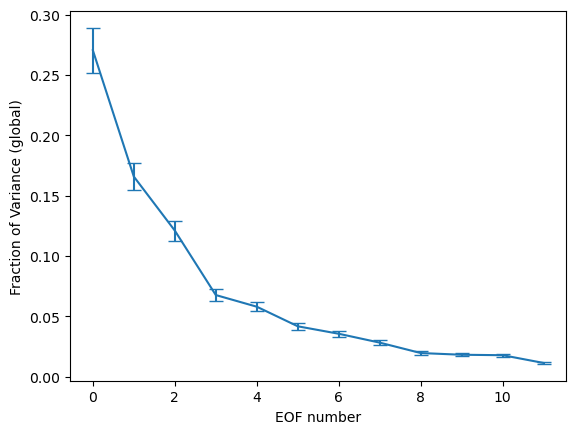

Confirm that this is a time series:  (1476,)


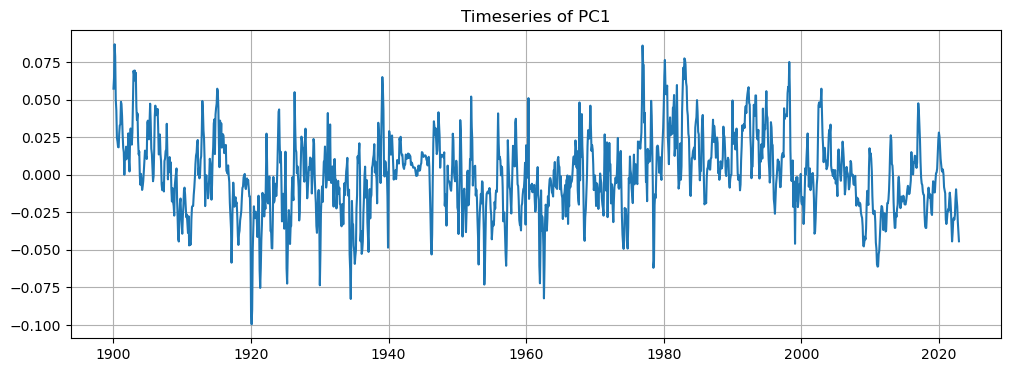

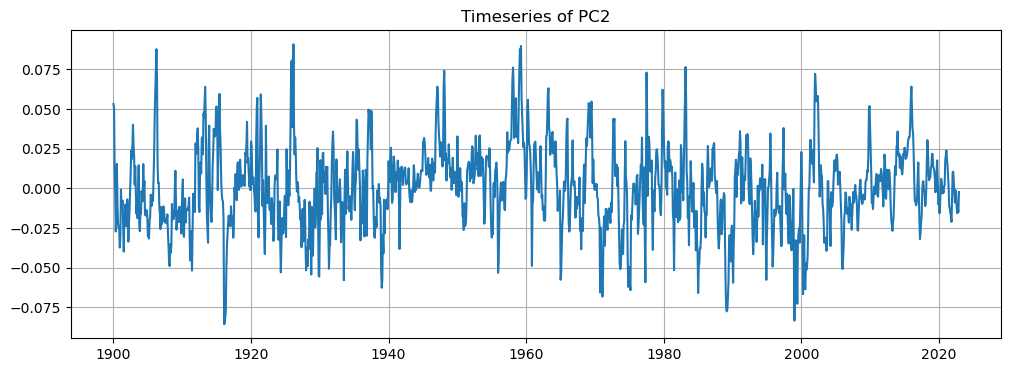

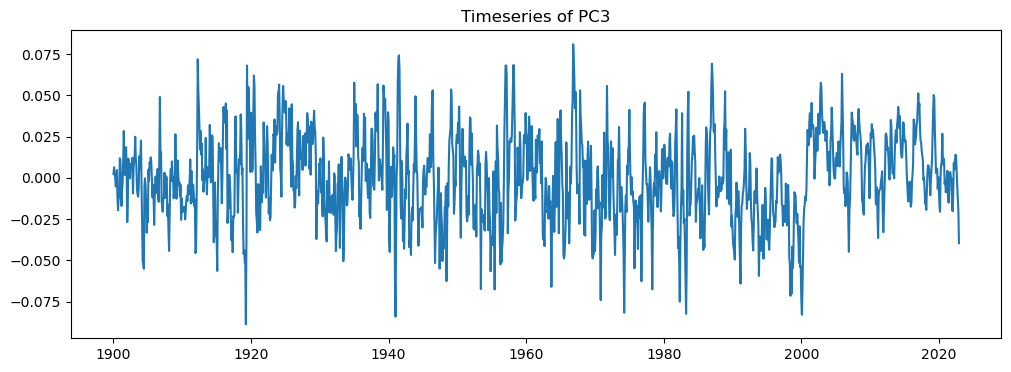

In [13]:
# Reformat from (lat, lon, month, year) to (space, time)
sst_so_time = xarray_monthly_to_time(sst_so)
sst_space_time_so = xarray_latlon_to_space(sst_so_time)
sst_space_time_so = sst_space_time_so.dropna(dim="space") # Drop all nans in space
sst_space_time_so = sst_space_time_so.dropna(dim="time") # Drop all nans in time

# First get degrees of freedom
# NOTE TO SELF: I don't understand Chapter 5 of text, so read Bretherton et al., 1999 instead
dof_sst = 429 

# Second Compute Eigenvalue Spectrum
u, s, vh = np.linalg.svd(sst_space_time_so.T)
spectrum = s*s.T
spectrum = spectrum/sum(spectrum)
yerror = spectrum*np.sqrt(2/dof_sst)

# Third Plot Eigenvalue Spectrum
def plot_eigenvalue_spectrum():
    """
    My values differ slightly from those generated by Dennis
    """
    index = np.linspace(0,24,25)
    plt.errorbar(index[0:12],spectrum[0:12],yerror[0:12],capsize=5)
    plt.ylabel('Fraction of Variance (Southern Ocean)')
    plt.xlabel('EOF number')
    plt.show()
    
plot_eigenvalue_spectrum()

# Plot time series of first eof
ts = vh[0,:]
print("Confirm that this is a time series: ", ts.shape)
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(sst_space_time.time,ts)
plt.title('Timeseries of PC1')
plt.grid()
# Plot time series of second eof
ts = vh[1,:]
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(sst_space_time.time,ts)
plt.title('Timeseries of PC2')
plt.grid()
# Plot time series of third eof
ts = vh[3,:]
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(sst_space_time.time,ts)
plt.title('Timeseries of PC3')
plt.grid()
plt.grid()

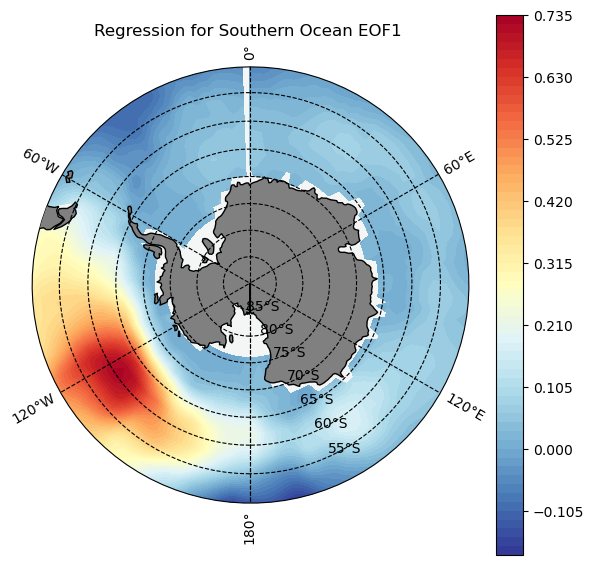

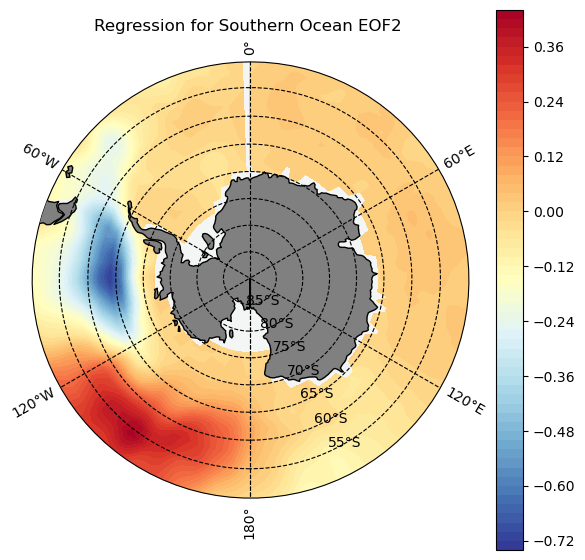

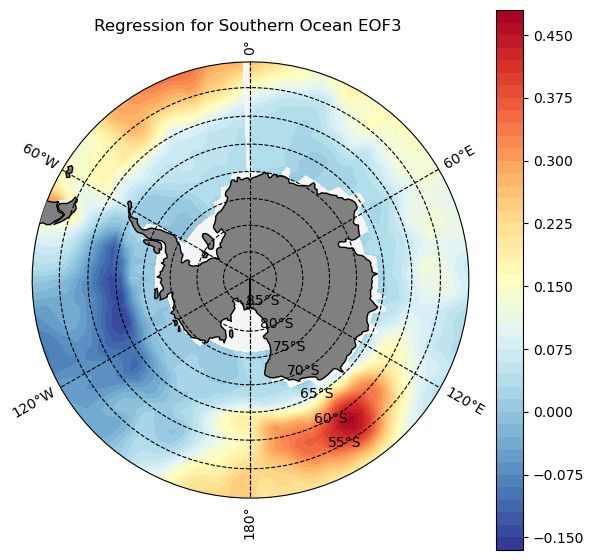

In [15]:
def so_regression_plot(reg, lat, lon, title): 
    # Sanity check selection of southern ocean
    fig, ax = plot_stationary_sp()
    img = ax.contourf(
        lon,
        lat,
        reg,
        60,
        transform=ccrs.PlateCarree(), 
        cmap="RdYlBu_r",
    )
    cbar2 = fig.colorbar(img, ax=ax)
    ax.set_title(f"Regression for Southern Ocean {title} ")
    fig.set_size_inches(6, 6)
    
def calc_regressions(
    df, # Original data frame
    pcs, # Principal components matrix
    num_regs=3, # Number of regressions to plot
    plot_func=True # Function to use for plotting 
):
    for i in range(num_regs):
        # Get first PC and standardize
        t = pcs[i,:]/np.std(pcs[i,:])
        # Regress first PC onto original data and divide by number samples
        reg = np.matmul(t, df.to_numpy()) / t.shape[0]
        reg_org = df[0]
        reg_org.values = reg
        reg_org = reg_org.unstack("space")

        so_regression_plot(
            reg_org, 
            lat=reg_org.lat, 
            lon=reg_org.lon,
            title=f"EOF{i+1}"
        )
    

calc_regressions(
    df=sst_space_time_so, 
    pcs=vh, 
    num_regs=3, 
    plot_func=True 
)

# Report

### Global
The eigenvalue spectrum derived from global SSTs suggests that there are only two distinct eigenvalues, explaining ~12% and ~6% of the global SST variability, respectively. The regression maps for the first eigenvector and the time series of the first principal component appear to correspond to variability driven by ENSO. The second eigenvector appears to correspond to variability due to global warming. The third regression map captures a spatial pattern remicient of the PDO. 

### Southern Ocean
The eigenvalue spectrum derived from Southern Ocean SSTs suggests that there are three distinct eigenvalues, explaining ~27%, ~17%, and 13% of Southern Ocean SST variability, respectively. The regression map for the first eigenvector and the time series of the first principal component may capture the long-term cooling of the southern ocean SSTs that has been observed in recent decades. It is less clear to me what physical modes of variability are captured by the second and third regression maps. My first guess, would be that the second regression map captures some combination of trends in the Southern Annual Mode and variations in the Amundsen Sea Low.